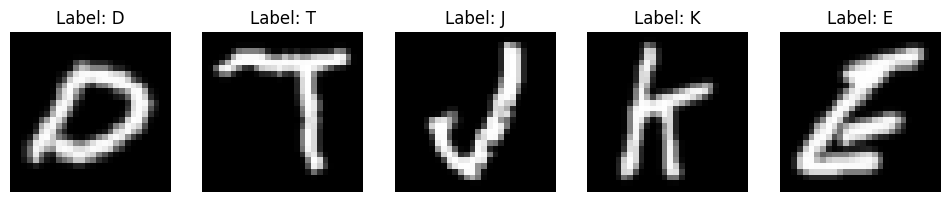

Total number of classes: 36
Total number of samples: 100800
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

#transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  
])

data_path = 'cnn_dataset'  
dataset = datasets.ImageFolder(root=data_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#  DataLoader - training, validation, testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def show_samples(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        ax.set_title(f"Label: {dataset.classes[labels[i]]}")
        ax.axis('off')
    plt.show()

show_samples(train_loader)


print("Total number of classes:", len(dataset.classes))
print("Total number of samples:", len(dataset))
print("Classes:", dataset.classes)

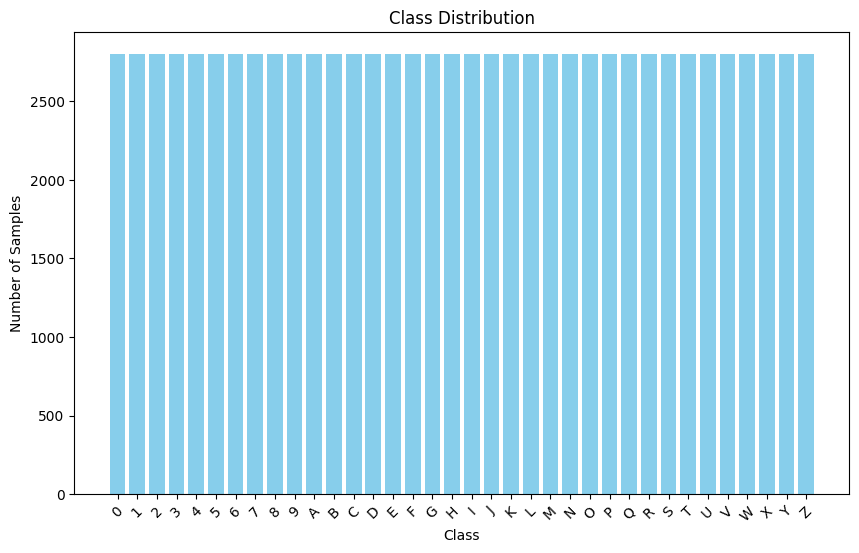

Class Counts: Counter({0: 2800, 1: 2800, 2: 2800, 3: 2800, 4: 2800, 5: 2800, 6: 2800, 7: 2800, 8: 2800, 9: 2800, 10: 2800, 11: 2800, 12: 2800, 13: 2800, 14: 2800, 15: 2800, 16: 2800, 17: 2800, 18: 2800, 19: 2800, 20: 2800, 21: 2800, 22: 2800, 23: 2800, 24: 2800, 25: 2800, 26: 2800, 27: 2800, 28: 2800, 29: 2800, 30: 2800, 31: 2800, 32: 2800, 33: 2800, 34: 2800, 35: 2800})


In [2]:
import collections

# Count the samples per class
class_counts = collections.Counter([label for _, label in dataset])
counts = [class_counts[i] for i in range(len(dataset.classes))]  


plt.figure(figsize=(10, 6))
plt.bar(dataset.classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

print("Class Counts:", class_counts)


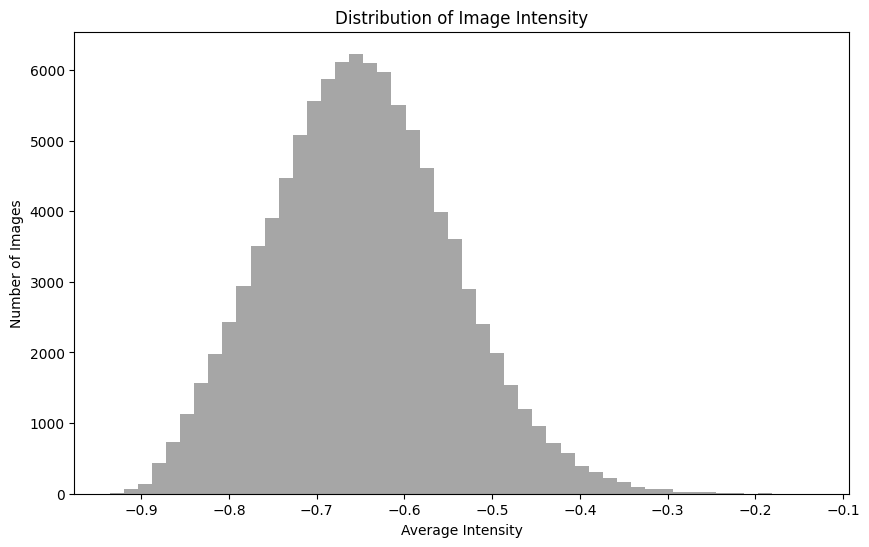

In [3]:
intensity_values = []

#  average intensity for each image
for img, _ in dataset:
    intensity_values.append(img.mean().item())  


plt.figure(figsize=(10, 6))
plt.hist(intensity_values, bins=50, color='gray', alpha=0.7)
plt.xlabel('Average Intensity')
plt.ylabel('Number of Images')
plt.title('Distribution of Image Intensity')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_39580\3246132878.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(intensity_data, labels=dataset.classes, vert=True)


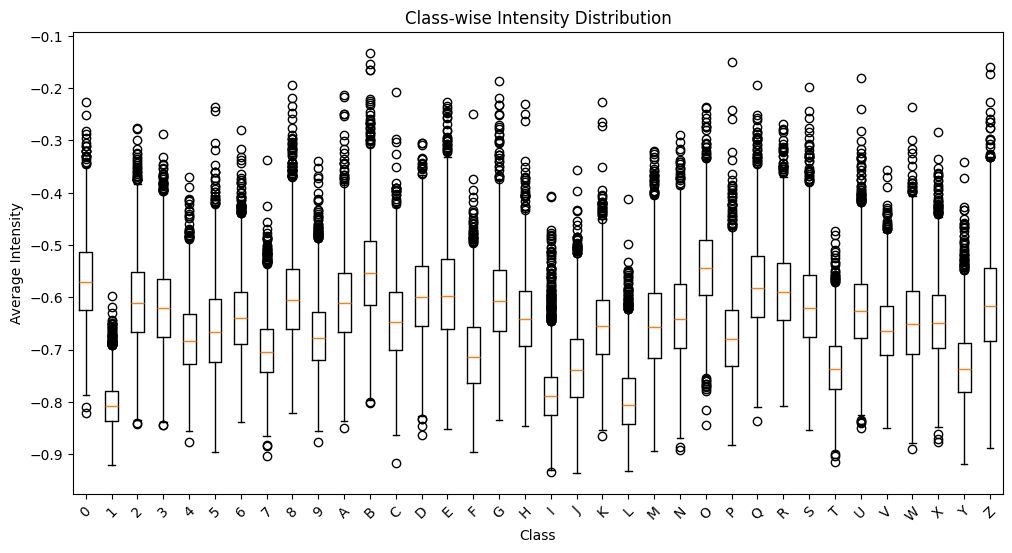

In [5]:
#intensity values for each class
class_intensity = {i: [] for i in range(len(dataset.classes))}

for img, label in dataset:
    avg_intensity = img.mean().item()
    class_intensity[label].append(avg_intensity)

intensity_data = [class_intensity[i] for i in range(len(dataset.classes))]

plt.figure(figsize=(12, 6))
plt.boxplot(intensity_data, labels=dataset.classes, vert=True)
plt.xlabel('Class')
plt.ylabel('Average Intensity')
plt.title('Class-wise Intensity Distribution')
plt.xticks(rotation=45)
plt.show()

In [8]:
!pip install torchinfo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
from torchinfo import summary  # Requires 'torchinfo' package

# Define  CNN 
class BasicCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(BasicCNN, self).__init__()
       
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1_input_features = None
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)  

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            self.fc1_input_features = x.size(1)
            self.fc1 = nn.Linear(self.fc1_input_features, 128).to(x.device)

        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = BasicCNN(num_classes=36)

summary(model, input_size=(64, 1, 28, 28))  


Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [64, 36]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 64, 7, 7]            18,496
├─MaxPool2d: 1-6                         [64, 64, 3, 3]            --
├─Dropout: 1-7                           [64, 128]                 --
├─Linear: 1-8                            [64, 36]                  4,644
Total params: 27,940
Trainable params: 27,940
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 124.53
Input size (MB): 0.20
Forward/backward pass size (MB): 11.26
Params size (MB): 0.11
Estimated Total Size (MB): 11.57

In [3]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
 
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    total_training_time = 0 
    for epoch in range(epochs):
        epoch_start_time = time.time()  
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = (correct / total)*100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        epoch_end_time = time.time()  
        epoch_duration = epoch_end_time - epoch_start_time 
        total_training_time += epoch_duration


        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Total training time: {total_training_time:.2f} seconds")
    return train_losses,train_accuracies,val_losses,val_accuracies

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (correct / total)*100
    return avg_val_loss, val_accuracy

# Train the model
train_losses_b,train_accuracies_b,valid_losses_b,valid_accuracies_b=train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [04:04<00:00,  5.16it/s]


Epoch [1/10], Train Loss: 1.0324, Train Accuracy: 67.2173, Validation Loss: 0.3716, Validation Accuracy: 86.5079


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:10<00:00,  9.63it/s]


Epoch [2/10], Train Loss: 0.5258, Train Accuracy: 82.0176, Validation Loss: 0.3219, Validation Accuracy: 87.8571


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:33<00:00,  8.21it/s]


Epoch [3/10], Train Loss: 0.4466, Train Accuracy: 84.3056, Validation Loss: 0.2775, Validation Accuracy: 89.9107


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [13:27<00:00,  1.56it/s]


Epoch [4/10], Train Loss: 0.4060, Train Accuracy: 85.6833, Validation Loss: 0.2665, Validation Accuracy: 90.3571


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [04:45<00:00,  4.41it/s]


Epoch [5/10], Train Loss: 0.3761, Train Accuracy: 86.5923, Validation Loss: 0.2626, Validation Accuracy: 89.8115


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:29<00:00,  8.42it/s]


Epoch [6/10], Train Loss: 0.3559, Train Accuracy: 87.3065, Validation Loss: 0.2557, Validation Accuracy: 90.3770


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [05:17<00:00,  3.97it/s]


Epoch [7/10], Train Loss: 0.3412, Train Accuracy: 87.7344, Validation Loss: 0.2555, Validation Accuracy: 90.4464


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [01:18<00:00, 16.08it/s]


Epoch [8/10], Train Loss: 0.3228, Train Accuracy: 88.1944, Validation Loss: 0.2480, Validation Accuracy: 91.0218


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [01:53<00:00, 11.13it/s]


Epoch [9/10], Train Loss: 0.3119, Train Accuracy: 88.5491, Validation Loss: 0.2527, Validation Accuracy: 90.2679


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [02:19<00:00,  9.05it/s]


Epoch [10/10], Train Loss: 0.3056, Train Accuracy: 88.7364, Validation Loss: 0.2484, Validation Accuracy: 90.4960
Total training time: 2604.79 seconds


In [4]:
from sklearn.metrics import accuracy_score

# evaluate accuracy on the test data
def evaluate_model(model, test_loader):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  #
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total)*100
    print(f"Accuracy on the test data: {accuracy :.2f}%")
    return accuracy

test_accuracy = evaluate_model(model, test_loader)


Accuracy on the test data: 90.67%


In [5]:
import torch
import torch.nn as nn
from torchinfo import summary

# Define CNN with Batch Normalization
class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes=36):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1_input_features = None
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes) 

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  

        if self.fc1 is None:
            self.fc1_input_features = x.size(1)
            self.fc1 = nn.Linear(self.fc1_input_features, 128).to(x.device)

        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_bn = CNNWithBatchNorm(num_classes=36).to(device)

summary(model_bn, input_size=(64, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
CNNWithBatchNorm                         [64, 36]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─BatchNorm2d: 1-2                       [64, 16, 28, 28]          32
├─MaxPool2d: 1-3                         [64, 16, 14, 14]          --
├─Conv2d: 1-4                            [64, 32, 14, 14]          4,640
├─BatchNorm2d: 1-5                       [64, 32, 14, 14]          64
├─MaxPool2d: 1-6                         [64, 32, 7, 7]            --
├─Conv2d: 1-7                            [64, 64, 7, 7]            18,496
├─BatchNorm2d: 1-8                       [64, 64, 7, 7]            128
├─MaxPool2d: 1-9                         [64, 64, 3, 3]            --
├─Dropout: 1-10                          [64, 128]                 --
├─Linear: 1-11                           [64, 36]                  4,644
Total params: 28,164
Trainable params: 28,164
Non-trainable params: 0
Tot

In [6]:
import torch.optim as optim
from tqdm import tqdm

#loss  and optimizer
criterion_bn = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)
 
train_losses_bn,train_accuracies_bn,valid_losses_bn,valid_accuracies_bn=train_model(model_bn, train_loader, val_loader, criterion_bn, optimizer_bn, epochs=10)


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:46<00:00,  7.57it/s]


Epoch [1/10], Train Loss: 0.8685, Train Accuracy: 72.4901, Validation Loss: 0.3141, Validation Accuracy: 88.5516


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:39<00:00,  7.91it/s]


Epoch [2/10], Train Loss: 0.4705, Train Accuracy: 83.7884, Validation Loss: 0.2782, Validation Accuracy: 89.7619


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:39<00:00,  7.91it/s]


Epoch [3/10], Train Loss: 0.4061, Train Accuracy: 85.8048, Validation Loss: 0.2582, Validation Accuracy: 90.3968


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:39<00:00,  7.91it/s]


Epoch [4/10], Train Loss: 0.3730, Train Accuracy: 86.9345, Validation Loss: 0.2530, Validation Accuracy: 90.3373


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:41<00:00,  7.78it/s]


Epoch [5/10], Train Loss: 0.3484, Train Accuracy: 87.5967, Validation Loss: 0.2508, Validation Accuracy: 90.4663


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:42<00:00,  7.76it/s]


Epoch [6/10], Train Loss: 0.3332, Train Accuracy: 88.0332, Validation Loss: 0.2510, Validation Accuracy: 90.6845


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [11:19<00:00,  1.85it/s]


Epoch [7/10], Train Loss: 0.3196, Train Accuracy: 88.4573, Validation Loss: 0.2487, Validation Accuracy: 90.3869


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:09<00:00,  9.72it/s]


Epoch [8/10], Train Loss: 0.3040, Train Accuracy: 88.9608, Validation Loss: 0.2262, Validation Accuracy: 91.8353


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:34<00:00,  8.16it/s]


Epoch [9/10], Train Loss: 0.2912, Train Accuracy: 89.4196, Validation Loss: 0.2386, Validation Accuracy: 91.4583


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [02:39<00:00,  7.91it/s]


Epoch [10/10], Train Loss: 0.2808, Train Accuracy: 89.7693, Validation Loss: 0.2314, Validation Accuracy: 91.4583
Total training time: 2237.39 seconds


In [7]:

# Evaluate model with Batch Normalization using test data
test_accuracy_bn = evaluate_model(model_bn, test_loader)


Accuracy on the test data: 91.13%


In [8]:
import torch.optim as optim
from tqdm import tqdm

#CNN model without Batch Normalization, Learning Rate Scheduler - independent evaluation
model_early_stopping = BasicCNN(num_classes=36).to(device)

criterion_es = nn.CrossEntropyLoss()
optimizer_es = optim.Adam(model_early_stopping.parameters(), lr=0.001)

patience = 3  

# Early Stopping Training function 
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):
    best_val_loss = float('inf')
    early_stop_count = 0

    train_losses_es = []
    val_losses_es = []
    train_accuracies_es = []
    val_accuracies_es = []
    total_training_time = 0  
    for epoch in range(epochs):
        epoch_start_time = time.time()  
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses_es.append(train_loss)
        train_accuracies_es.append(train_accuracy)

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses_es.append(val_loss)
        val_accuracies_es.append(val_accuracy)

        epoch_end_time = time.time()  
        epoch_duration = epoch_end_time - epoch_start_time  
        total_training_time += epoch_duration

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0  
            print("Validation loss improved, resetting early stopping counter.")
        else:
            early_stop_count += 1
            print(f"No improvement in validation loss. Early stopping count: {early_stop_count}/{patience}")
            if early_stop_count >= patience:
                print("Early stopping triggered. Stopping training.")
                break
    print(f"Total training time: {total_training_time:.2f} seconds")
    return train_losses_es,train_accuracies_es,val_losses_es,val_accuracies_es

# Train model using early stopping
train_losses_es,train_accuracies_es,valid_losses_es,valid_accuracies_es=train_model_with_early_stopping(model_early_stopping, train_loader, val_loader, criterion_es, optimizer_es, patience, epochs=10)


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:22<00:00,  8.85it/s]


Epoch [1/10], Train Loss: 1.2565, Train Accuracy: 0.6159, Validation Loss: 0.4593, Validation Accuracy: 85.0694
Validation loss improved, resetting early stopping counter.


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:21<00:00,  8.93it/s]


Epoch [2/10], Train Loss: 0.6544, Train Accuracy: 0.7838, Validation Loss: 0.3861, Validation Accuracy: 86.7460
Validation loss improved, resetting early stopping counter.


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:22<00:00,  8.87it/s]


Epoch [3/10], Train Loss: 0.5665, Train Accuracy: 0.8107, Validation Loss: 0.3545, Validation Accuracy: 87.5794
Validation loss improved, resetting early stopping counter.


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:19<00:00,  9.05it/s]


Epoch [4/10], Train Loss: 0.5232, Train Accuracy: 0.8229, Validation Loss: 0.3223, Validation Accuracy: 88.8294
Validation loss improved, resetting early stopping counter.


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:23<00:00,  8.81it/s]


Epoch [5/10], Train Loss: 0.4839, Train Accuracy: 0.8342, Validation Loss: 0.3102, Validation Accuracy: 89.2063
Validation loss improved, resetting early stopping counter.


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:21<00:00,  8.91it/s]


Epoch [6/10], Train Loss: 0.4603, Train Accuracy: 0.8425, Validation Loss: 0.3026, Validation Accuracy: 88.7401
Validation loss improved, resetting early stopping counter.


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:17<00:00,  9.14it/s]


Epoch [7/10], Train Loss: 0.4464, Train Accuracy: 0.8465, Validation Loss: 0.3102, Validation Accuracy: 88.5714
No improvement in validation loss. Early stopping count: 1/3


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:25<00:00,  8.67it/s]


Epoch [8/10], Train Loss: 0.4299, Train Accuracy: 0.8512, Validation Loss: 0.2868, Validation Accuracy: 89.8016
Validation loss improved, resetting early stopping counter.


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:27<00:00,  8.53it/s]


Epoch [9/10], Train Loss: 0.4175, Train Accuracy: 0.8551, Validation Loss: 0.2872, Validation Accuracy: 89.5635
No improvement in validation loss. Early stopping count: 1/3


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [02:25<00:00,  8.63it/s]


Epoch [10/10], Train Loss: 0.4073, Train Accuracy: 0.8577, Validation Loss: 0.2839, Validation Accuracy: 89.8611
Validation loss improved, resetting early stopping counter.
Total training time: 1567.14 seconds


In [9]:
test_accuracy_es = evaluate_model(model_early_stopping, test_loader)

Accuracy on the test data: 89.55%


In [10]:

model_lr_scheduler= BasicCNN(num_classes=36).to(device)


criterion_lr = nn.CrossEntropyLoss()
optimizer_lr= optim.Adam(model_lr_scheduler.parameters(), lr=0.001)

# Learning Rate Scheduler (
scheduler_lr = optim.lr_scheduler.StepLR(optimizer_lr, step_size=3, gamma=0.1)

def train_model_with_lr_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    
    train_losses_lr = []
    val_losses_lr = []
    train_accuracies_lr = []
    val_accuracies_lr = []
    total_training_time=0
    for epoch in range(epochs):
        epoch_start_time = time.time()  
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses_lr.append(train_loss)
        train_accuracies_lr.append(train_accuracy)

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses_lr.append(val_loss)
        val_accuracies_lr.append(val_accuracy)

        epoch_end_time = time.time()  
        epoch_duration = epoch_end_time - epoch_start_time  
        total_training_time += epoch_duration

        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
              f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    print(f"Total training time: {total_training_time:.2f} seconds")
    return train_losses_lr,train_accuracies_lr,val_losses_lr,val_accuracies_lr

# Train  model using Learning Rate Scheduler
train_losses_lr,train_accuracies_lr,valid_losses_lr,valid_accuracies_lr=train_model_with_lr_scheduler(model_lr_scheduler, train_loader, val_loader, criterion_lr, optimizer_lr, scheduler_lr, epochs=10)


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [08:17<00:00,  2.53it/s]


Epoch [1/10], Train Loss: 1.2611, Train Accuracy: 0.6109, Validation Loss: 0.4668, Validation Accuracy: 84.6726, Learning Rate: 0.001000


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:14<00:00,  9.39it/s]


Epoch [2/10], Train Loss: 0.6726, Train Accuracy: 0.7769, Validation Loss: 0.3833, Validation Accuracy: 86.9742, Learning Rate: 0.001000


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:24<00:00,  8.73it/s]


Epoch [3/10], Train Loss: 0.5804, Train Accuracy: 0.8058, Validation Loss: 0.3503, Validation Accuracy: 87.3909, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:24<00:00,  8.72it/s]


Epoch [4/10], Train Loss: 0.5115, Train Accuracy: 0.8266, Validation Loss: 0.3290, Validation Accuracy: 88.3532, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [03:54<00:00,  5.38it/s]


Epoch [5/10], Train Loss: 0.4942, Train Accuracy: 0.8333, Validation Loss: 0.3263, Validation Accuracy: 88.4821, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:01<00:00, 10.38it/s]


Epoch [6/10], Train Loss: 0.4877, Train Accuracy: 0.8360, Validation Loss: 0.3222, Validation Accuracy: 88.5020, Learning Rate: 0.000010


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:11<00:00,  9.58it/s]


Epoch [7/10], Train Loss: 0.4815, Train Accuracy: 0.8392, Validation Loss: 0.3200, Validation Accuracy: 88.4921, Learning Rate: 0.000010


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:22<00:00,  8.87it/s]


Epoch [8/10], Train Loss: 0.4836, Train Accuracy: 0.8379, Validation Loss: 0.3193, Validation Accuracy: 88.6409, Learning Rate: 0.000010


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1260/1260 [02:23<00:00,  8.79it/s]


Epoch [9/10], Train Loss: 0.4824, Train Accuracy: 0.8385, Validation Loss: 0.3186, Validation Accuracy: 88.6706, Learning Rate: 0.000001


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [02:23<00:00,  8.79it/s]


Epoch [10/10], Train Loss: 0.4794, Train Accuracy: 0.8392, Validation Loss: 0.3185, Validation Accuracy: 88.6310, Learning Rate: 0.000001
Total training time: 1973.94 seconds


In [11]:
test_accuracy_lr = evaluate_model(model_lr_scheduler, test_loader)

Accuracy on the test data: 88.43%


In [12]:

model_save_path = "best_model_with_batch_norm_part3.pth"

# Save the model
torch.save(model_bn.state_dict(), model_save_path)
print(f"Model with Batch Normalization saved to {model_save_path}")


Model with Batch Normalization saved to best_model_with_batch_norm_part3.pth


In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model_performance(model, test_loader):
    model.eval()  
    all_predictions = []
    all_labels = []

    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
    print(f"Precision (macro average): {precision*100:.4f}")
    print(f"Recall (macro average): {recall*100:.4f}")
    print(f"F1 Score (macro average): {f1*100:.4f}")

    return all_labels,all_predictions,accuracy, precision, recall, f1

# Evaluate best model on test data
all_labels_bn,all_predictions_bn,test_accuracy_best, test_precision_best, test_recall_best, test_f1_best = evaluate_model_performance(model_bn, test_loader)


Test Accuracy: 91.13%
Precision (macro average): 91.5283
Recall (macro average): 90.8730
F1 Score (macro average): 90.7533


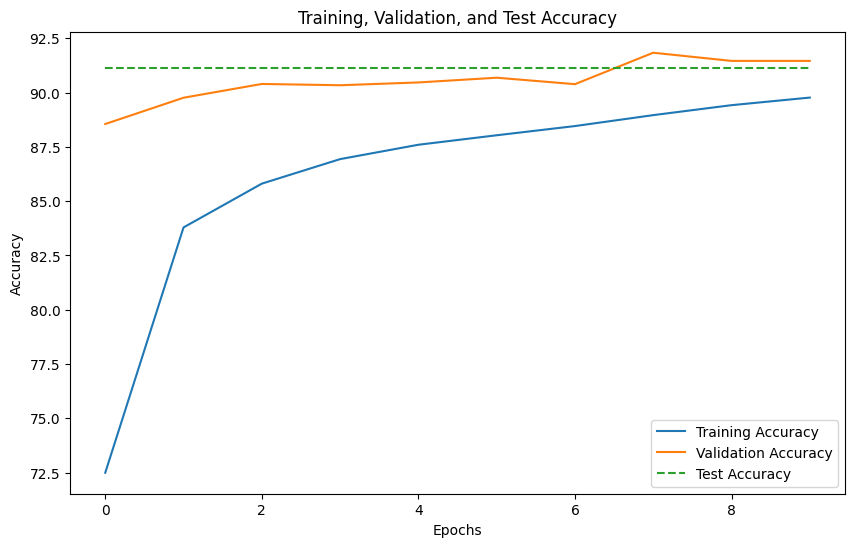

In [14]:
import matplotlib.pyplot as plt

test_accuracies_bn = [test_accuracy_bn] * len(train_accuracies_bn)

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_bn, label='Training Accuracy')
plt.plot(valid_accuracies_bn, label='Validation Accuracy')
plt.plot(test_accuracies_bn, label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


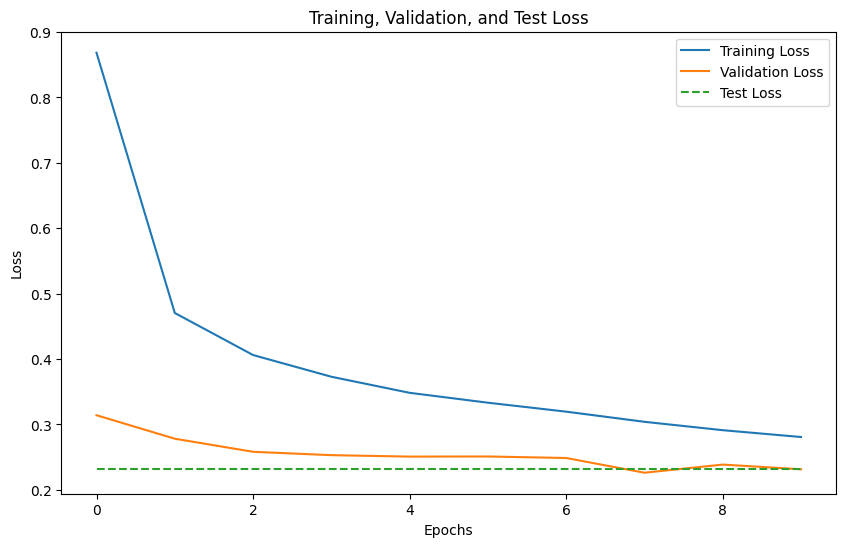

In [15]:

test_losses_bn = [valid_losses_bn[-1]] * len(train_losses_bn)

plt.figure(figsize=(10, 6))
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(valid_losses_bn, label='Validation Loss')
plt.plot(test_losses_bn, label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


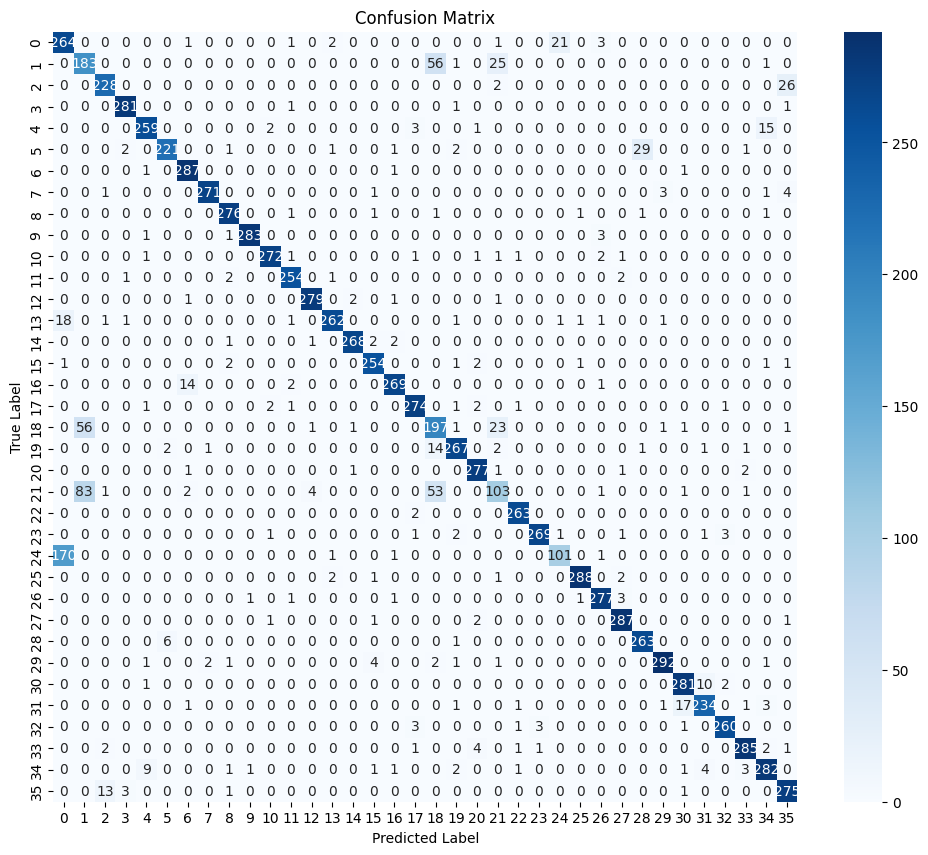

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix_bn = confusion_mat
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_bn, annot=True, fmt="d", cmap="Blues", xticklabels=range(36), yticklabels=range(36))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


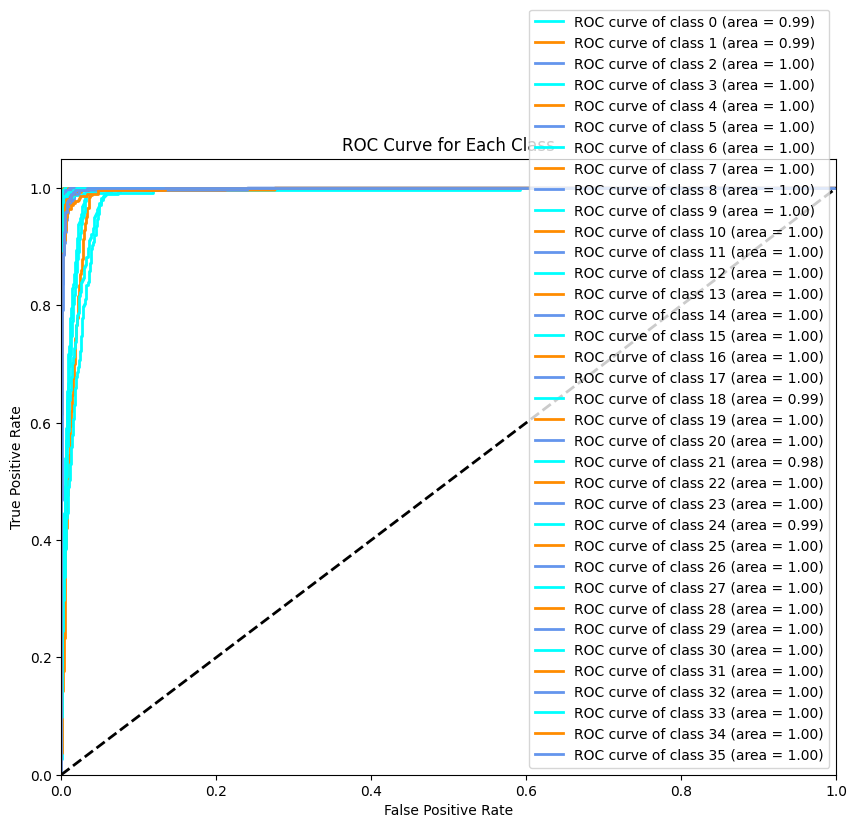

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(all_labels_bn, classes=range(36))
n_classes = y_test_bin.shape[1]

model.eval()
all_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
